<p style="font-weight:600; font-size:36px">Model Fitting in Python</p>

<p style="font-weight:400; font-size:24px">Jeremy A. Koch -- 21 Dec 2020</p>



This notebook contains code examples for fitting data with complicated implementations. Included are fits to:
1. a functional model with data spanning orders of magnitude
2. a two-state functional model with two separate data sets
3. a first-order ODE model with without a known initial condition
4. a second-order ODE model

Some useful snippets are included at the end.

We import the essential modules in the first cell -- if you borrow things from this document, make sure you include the relevant imports.

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
%matplotlib inline

# Fit a function spanning orders-of-magnitude:

Given data $(x,y)$, where $y$ spans orders of magnitude, fit a curve $y=f(x)$. Here we use $y=c x^m$ for parameters $m$ and $c$, with $0.1<y<60$.

For data that spans multiple orders of magnitude, a direct curve_fit will gloss over the error for small values (errors are arithmetic differences, so a 500% error on 0.1 is "smaller" than a 1% error on 100). If you trust the small data and wish to find meaning in it, you have to add weight to it. Demonstrated here.

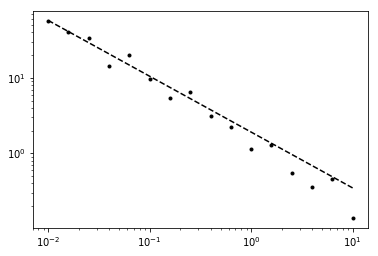

direct fit (dashed): m= -0.74 , c= 1.913


In [2]:
# import numpy as np
# from scipy.optimize import curve_fit
# import matplotlib.pyplot as plt

# some data
x_data=np.array([0.01,0.0158,0.0251,0.0398,0.0631,0.1,0.158,0.251,0.398,0.631,1,1.58,2.51,3.98,6.31,10])
y_data=np.array([57.09,40.93,33.45,14.20,20.05,9.743,5.424,6.545,3.119,2.258,1.130,1.285,0.5426,0.3565,0.4626,0.1386])

# function
def pwrlaw(x,m,c): # independent variable x, two parameters m & c
    return c*x**m

# direct curve_fit to the (x,y) data set
fits, _ = curve_fit(pwrlaw, x_data, y_data) # fitted parameters stored as array fits
# we ignore the second output of this command, which is something like the error tolerance, by using _

m=fits[0]
c=fits[1]

# plotting
plt.loglog(x_data,y_data,'k.')
plt.loglog(x_data,pwrlaw(x_data,m,c),'k--') # can call the function directly in plotting commands
plt.show()
print("direct fit (dashed):","m=",m.round(decimals=3),", c=",c.round(decimals=3))

In the above, the fit for y<3 deviates considerably from the data. This can be alleviated by taking the log10 of the data and using a log10 of the fitting function. One possible implementation, without having to change the definition of the fitting function, uses a python lambda function (a function that is defined anonymously inline):

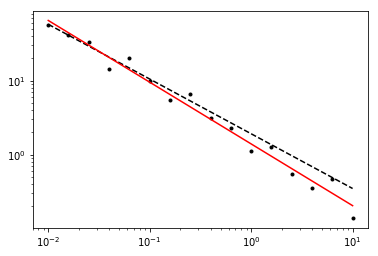

direct fit (dashed) m= -0.74 , c= 1.913
log fit (red) m= -0.834 , c= 1.394


In [3]:
# curve_fit with the log of the data. 
# lambda defines an inline function of variables x,m,c,
# which we immediately use to call the fitting function pwrlaw(x,m,c)
# through the prism of np.log10, making sure to take np.log10 of the y-data to be fit
fits_log, _ = curve_fit(lambda x,m,c: np.log10(pwrlaw(x,m,c)), x_data, np.log10(y_data))

m_log=fits_log[0]
c_log=fits_log[1]

#plotting
plt.loglog(x_data,y_data,'k.')                     # exp data
plt.loglog(x_data,pwrlaw(x_data,m,c),'k--')        # direct fit
plt.loglog(x_data,pwrlaw(x_data,m_log,c_log),'r-') # log fit
plt.show()

print("direct fit (dashed)","m=",m.round(decimals=3),", c=",c.round(decimals=3))
print("log fit (red)","m=",m_log.round(decimals=3),", c=",c_log.round(decimals=3))

# Simultaneous fit for model with two states:

Given two data sets $(x_1,y_1)$ and $(x_2,y_2)$ (example for rheologists: $G'$ and $G''$ data), fit $y_1=f(x_1;a,b,c)$ and $y_2=g(x_2;a,b,c)$. Here as an example we use a rheological model from:
  
  _C Hanotin, S Kiesgen de Richter, LJ Michot, Ph Marchal. "Viscoelasticity of vibrated granular suspensions." Journal of rheology (2015)._  
  
...with two states and four parameters:

* with no vibration: $\tau = G \gamma_\text{c} + \eta_\text{H} \dot{\gamma}.\quad\quad$ 
* with vibration: $\tau = \gamma_\text{c}\frac{G+\eta_\text{H}~f_\text{B}}{\dot{\gamma}+\gamma_\text{c}~f_\text{B}}\dot{\gamma}+\frac{\eta_\text{H}}{\dot{\gamma}+\gamma_\text{c}~f_\text{B}}\dot{\gamma}^2$

For a simultaneous fit, we must stitch together the two data sets and create different fitting targets for each half of the 
data. As such, a direct ```curve_fit``` will not work -- we must go deeper and use ```least_squares```.



I worked with this a lot in my dissertation, data from here: 
  
_JA Koch, DI Castaneda, RH Ewoldt, DA Lange. "Vibration of fresh concrete understood through the paradigm of granular physics." Cement and Concrete Research (2019)._

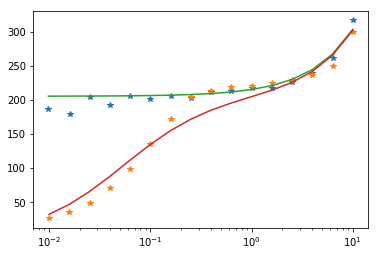

G= 1496.528 , gamma_c= 0.137 , eta_H= 9.792 , f_B= 0.39


In [4]:
# import numpy as np
# from scipy.optimize import least_squares
# import matplotlib.pyplot as plt

# some data
x_v_data=np.array([9.99991,6.30959,3.98105,2.51174,1.58487,0.99994,0.63104,0.39806,0.25115,0.15849,
              0.09999,0.0631,0.0398,0.02512,0.01585,0.01])     # during vibration
y_v_data=np.array([300.297,250.444,237.17,229.641,224.519,220.818,218.62,213.132,204.573,172.079,
              135.38,99.5142,71.0392,49.0162,35.9663,26.9438]) # during vibration
x_u_data=np.array([10.0002,6.30945,3.98143,2.51179,1.58505,0.99994,0.63107,0.3981,0.25121,0.15851,
              0.09994,0.06301,0.03992,0.02517,0.016,0.00986])  # no vibration
y_u_data=np.array([316.604,260.901,239.982,226.806,218.124,216.893,212.678,211.504,203.419,206.058,
              201.123,205.835,192.87,204.989,179.441,187.024]) # no vibration

# functions for TWO states: 
def u(x,G,gc,nH,fB): # no vibration... independent variable x and four parameters
    return G*gc+nH*x

def v(x,G,gc,nH,fB): # with vibration
    return gc*(G+nH*fB)/(x+gc*fB)*x+nH/(x+gc*fB)*x**2

# Here, the data is not fit to a single function. We instead define different targets
# for each half of the data and then stitch the two sets into a single residual function 
# that gets least_squares-ified.
def res_two_fxns(fits,x_v_data,y_v_data,x_u_data,y_u_data): 
    G =fits[0]
    gc=fits[1]
    nH=fits[2]
    fB=fits[3]

    #vib data
    diff_v=y_v_data-v(x_v_data,G,gc,nH,fB)
    #unv data
    diff_u=y_u_data-u(x_u_data,G,gc,nH,fB)

    return np.append(diff_v,diff_u)
    # An array of differences between fit and data at each data point.
    # This is the residuals function that the least squares routine is
    # trying to minimize.

# initial guess for parameters
fit_guess=np.array([1000.,.2,10.,1.])

# fit occurs through least_squares instead of curve_fit,
result=least_squares(res_two_fxns,fit_guess,args=(x_v_data,y_v_data,x_u_data,y_u_data),bounds=(0, np.inf))
# bounds can be used (including with an array for each parameter, e.g., bounds=([0, 0, -10, 1], [1, 1, 1, 3])
# to focus the hunt for the optimum, prevent parameter from going negative, etc.

G =result.x[0]  # output is slightly more complicated than that of curve_fit. result.x is an array of fits
gc=result.x[1]
nH=result.x[2]
fB=result.x[3]


# plotting
plt.semilogx(x_u_data,y_u_data,'*')
plt.semilogx(x_v_data,y_v_data,'*')
plt.semilogx(x_u_data,u(x_u_data,G,gc,nH,fB),'-')
plt.semilogx(x_v_data,v(x_v_data,G,gc,nH,fB),'-')
plt.show()

print("G=",G.round(decimals=3),", gamma_c=",gc.round(decimals=3),", eta_H=",nH.round(decimals=3),", f_B=",fB.round(decimals=3))

# Fit a first-order ODE model:

Given data $(t,x)$, fit a first-order ODE: $x'=f(x,t)$. Here we fit $y' = -y/\tau$, which could be solved analytically and then fit. But let's demonstrate an ODE fit, including the fit to the initial condition.

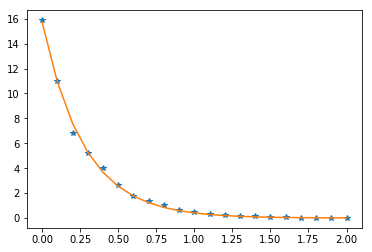

y0= 15.718 , tau= 0.275


In [5]:
# import numpy as np
# from scipy.integrate import odeint
# from scipy.optimize import curve_fit
# import matplotlib.pyplot as plt

# some data
t_data=np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2])
y_data=np.array([15.88,11.04,6.845,5.232,4.003,2.643,1.790,1.402,1.060,0.6837,0.5205,0.3402,0.2777,
                 0.1704,0.1265,0.09785,0.06003,0.04246,0.03522,0.02437,0.01563])

def s_dot(y,t,tau): # the actual ODE, but this is not called directly by curve_fit
    return -y/tau

def s(t,y0,tau):    # the fitting function called by curve_fit with two parameters: y0 and tau
    y_fit=odeint(s_dot, y0, t, args=(tau,))
    # args expects a duple of parameters, but we only have one, so we have to use the silly looking (tau,)
    return y_fit[:,0]

# curve_fit calls a function that returns y. That y comes from an ODE for y_prime called via odeint.
# So we are fitting y-data to the parameters in the ODE.
fits,_=curve_fit(s,t_data,y_data,bounds=(0, np.inf))
y0=fits[0]
tau=fits[1]


# plotting
plt.plot(t_data,y_data,'*')
plt.plot(t_data,s(t_data,y0,tau),'-')
plt.show()

print("y0=",y0.round(decimals=3),", tau=",tau.round(decimals=3))

# Fit a second-order ODE model:

Damped harmonic oscillator: $\ddot{x}+2\zeta \omega_0 \dot{x} + \omega_0^2 x = 0$, including a fit to the initial conditions. Similar to above.


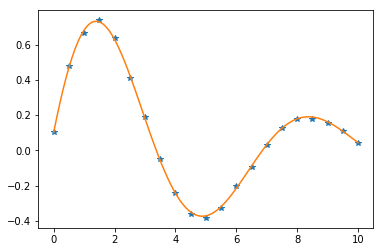

y0= 0.102 , yp0= 0.859 , z= 0.21 , w0= 0.921


In [6]:
# import numpy as np
# from scipy.integrate import odeint
# from scipy.optimize import curve_fit
# import matplotlib.pyplot as plt

# some data
t_data=np.array([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10])
y_data=np.array([0.1037,0.4765,0.6634,0.7385,0.6364,0.4109,.1918,-0.0506,-0.2429,
                 -0.3637,-0.3833,-0.3242,-0.2041,-0.0929,0.0300,0.1258,0.1763,0.1769,0.1559,0.1096,0.0428])

# second order equations get solved via odeint, but with a array input:
# Y=(yp,y), "y prime" and y, parameters z and w0.
def ODE2(Y,t,z,w0): 
    yp,y = Y
    ypp = -2*z*w0*yp- w0**2*y
    return [ypp,yp]

def fit_ODE(t,yp0,y0,z,w0):
    Y0=[yp0,y0]
    y_fit=odeint(ODE2, Y0, t, args=(z,w0))
    return y_fit[:,1] # returns the fit to the y data

fits,_=curve_fit(fit_ODE,t_data,y_data,bounds=(0, np.inf))


yp0=fits[0]
y0 =fits[1]
z  =fits[2]
w0 =fits[3]


# plotting
t_fit=np.linspace(0,max(t_data),100) # smooth function with more data
plt.plot(t_data,y_data,'*')
plt.plot(t_fit,fit_ODE(t_fit,yp0,y0,z,w0),'-')
plt.show()

print("y0=",y0.round(decimals=3),", yp0=",yp0.round(decimals=3),", z=",z.round(decimals=3),", w0=",w0.round(decimals=3))

# Additional notes

1. I usually upload data from csv files because that method consistently worked, but you might have success with other filetypes. The following uploads a csv file, located in the current working directory, into a numpy "array" (actually a matrix), with the first column being ```x```-data and the second being ```y```-data.
~~~~
data = np.loadtxt(open("speed_data.csv"),delimiter=',',dtype=np.float)
x=data[:,0]
y=data[:,1]
~~~~
you may additionally find (from the pandas package) a bit of code like
~~~~
import pandas as pd
x=pd.read_clipboard(header=None) 
t=x.values[:,0]
E=x.values[:,1]
~~~~
to be useful -- it reads in data on your clipboard, e.g. after copying from excel. If the columns of data have headers (e.g., variable names or units) must change to ```header=[0,1]```.



2. Piecewise functions are probably easiest to define using python lambda functions. Below, the function returns zero until ```x``` reaches a critical value ```Ec```, with $E_c$ potentially being a parameter in the fit.
~~~~
def Fx(x,T,Ec,n):
    y = np.piecewise(x, [x < Ec, x >= Ec], [lambda x:0, lambda x:1./T*((x/Ec)**2.-1.)**n])
    return y
~~~~
3. Sometimes you will have a model with a parameter that you DO NOT want to fit (e.g., if the parameter is a controlled input in the experiment). We can handle this with a lambda function. Below, ```x``` is a function of ```t,a,b,Q```. To avoid fitting ```Q```, we define a lambda function that depends on ```t,a,b``` and not on ```Q```. Then technically ```curve_fit``` is performed on the lambda function, not on the original function ```x```.
~~~~
def x(t,a,b,Q):
    return Q+a*t+b*t**2
Q=2.5
fits,_=curve_fit(lambda t,a,b: x(t,a,b,Q),t_data,x_data,bounds=(0, np.inf))
~~~~